# Text Mining experiment with GitHub pull request
- Extract text information from Github pullrequest avaible in .csv
- Preprocess issue (tokenizer-stopwords- lemmatization)
- Generation of topic models and issue corpus(tf,tf-id) for the different algorithms (LSI,LDA,HDP,LDAMALLET).
- Evaluation document characterizacion : Topic model vs TF_IDF
    - Evaluate classifier MultinomialNB
    - Evaluate classifier with multiclass SVN DecisionTreeClassifier
    - Evaluate classifier MultinomialNB with Binary
    - Evaluate classifier MultiLabel: DecisionTreeClassifier

## Load  the csv files with the issues available in./datasets/issue/ 

In [43]:
## Load issue
import os
import glob
import pandas as pd
#Read csv
def loadCsvPullRequestFolder(path):
    """Load issue data from  csv files  and generate a 
    list with all issue
    Parameters:
        ----------
        path : folder path with csv file issue information. 
            id issue
            title issue test
            body issue test
            commentsBodies test
            'Label category: bug' text boolean is bug
            isLabeled text boolean 
            isPullRequest text boolean
     Returns:
        -------  
        _totalfile number of file read
        len(_liss) number of issue read
        _liss list of total issues
        dftotal dataframe with total issues   
        
    """
    _lpr=list()
    _totalfile=0
    dftotal=pd.DataFrame()
    for filename in glob.glob(os.path.join(path, '*.csv')):        
        print(filename)
        df2=pd.read_csv(filename, error_bad_lines=False, index_col=False, dtype='unicode')
        df2["pull_request"] = df2["pull_request_body"].map(str) + " " +  df2["pull_request_title"].map(str)
       
        
        [_lpr.append(pr) for pr in df2.pull_request] 
        _totalfile+=1
        dftotal=dftotal.append(df2)    
        #print(lprbt[len(lprbt)-1])
    #del dftotal['body']  
    #del dftotal['id'] 
    #del dftotal['commentsBodies']
    #del dftotal['title']
    
    return _totalfile, len(_lpr), _lpr, dftotal


totalfiles,totalinstances,lprbt,df=loadCsvPullRequestFolder(path="./datasets/pullrequest/")   
print("Number of files: {} Number of instances in list: {}".format(totalfiles,totalinstances))
print("Number of instance in dataframe {}".format(df.shape[0]))
#df.tail(2)

./datasets/pullrequest/reviews_Leaflet_processed.csv
./datasets/pullrequest/reviews_playframework_processed.csv
./datasets/pullrequest/reviews_angular.js_processed.csv
./datasets/pullrequest/reviews_WebFundamentals_processed.csv
./datasets/pullrequest/reviews_appium_processed.csv
./datasets/pullrequest/reviews_Chart.js_processed.csv
./datasets/pullrequest/reviews_cakephp_processed.csv
./datasets/pullrequest/reviews_elasticsearch_processed.csv
Number of files: 8 Number of instances in list: 4303
Number of instance in dataframe 4303


## Preprocess issue (tokenizer-stopwords- lemmatization)
Library spaCy first tokenizes the text to produce a Doc object. 
The Doc is then processed in several different steps – this is also referred to as the processing pipeline. 
The pipeline used by the default models consists of a tagger, a parser and an entity recognizer. 
Each pipeline component returns the processed Doc, which is then passed on to the next component.

In [44]:
##Preprocessing data
import LibraryTopicModel as ltm
import spacy

lprbt=ltm.textNormalization(lprbt)                
prwords=list(ltm.pr_to_words(lprbt))
print("Numbers of tokens in issue: {} ".format(ltm.counterElements(prwords)))
data_words_nostops = ltm.remove_stopwords(prwords)
print("Numbers of tokens in issue with out nostops: {} ".format(ltm.counterElements(data_words_nostops)))
nlp = spacy.load('en', disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
%time data_lemmatized = ltm.lemmatization(nlp,data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print("Numbers of tokens in issue after lemmatization: {} ".format(ltm.counterElements(data_lemmatized)))

Numbers of tokens in issue: 270374 
Numbers of tokens in issue with out nostops: 178005 
CPU times: user 1min 19s, sys: 1.24 s, total: 1min 21s
Wall time: 51.2 s
Numbers of tokens in issue after lemmatization: 166970 


## Generation of topic models and issue corpus for the different algorithms (LSI,LDA,HDP,LDAMALLET).
Models and corpus are stored in folder ./models/issue/.
In our case study we'll use LDAMALLET implementation

In [48]:
## Creating corpus an dictionary
import gensim.models.tfidfmodel as tfidmodel
import gensim.models.tfidfmodel as tfidf
import gensim.corpora as corpora
import gensim.models.ldamodel as ldamodel
import gensim.models.wrappers.ldamallet as ldamallet
import gensim.models.hdpmodel as hdpmodel


#save dictionary
def createCorpusDictionary(data_lemmatized):
    """Create a corpus (TF and TF-IDF from issues preprocessed (tokenized and lemmatized).
    Corpus and dictinary are saved in files.
    Parameters:
        ----------
        data_lemmatized : data preprocessed 
     Returns:
        -------  
        corpus - document word representation TF-IDF
        id2word - dictionary 
     """   
    id2word = corpora.Dictionary(data_lemmatized)
    #Let's filter out both very infrequent words and very frequent words (stopwords), to clear up resources as well as remove noise.
    #ignore words that appear in less than 20 documents or more than 10% documents
    #id2word.filter_extremes(no_below=10, no_above=0.1)
    id2word.save('./models/issue/dict_issues')
    id2word.save_as_text('./models/issue/dict_issues.txt')
    # Create Corpus
    texts = data_lemmatized
    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    corpora.MmCorpus.serialize('./models/issue/istfcorpus.mm', corpus)
    return corpus,id2word

def createCorpusTfid(corpus):
    tfidf = tfidmodel.TfidfModel(corpus)
    corpus_tfidf = tfidf[corpus]
    corpora.MmCorpus.serialize('./models/issue/istfidcorpus.mm',corpus_tfidf )
    return corpus_tfidf

def createLDA(corpus, id2word):
    ldamodeliss = ldamodel.LdaModel(corpus, id2word=id2word, num_topics=10)
    #ldamodelpr.print_topics(2)
    ldamodeliss.save("./models/issue/ldamodeliss")
    corpora.MmCorpus.serialize('./models/issue/isldatfidcorpus.mm',ldamodeliss[corpus])
    return ldamodeliss 


def createLDAMallet(corpus, id2word):
    mallet_path="./mallet-2.0.8/bin/mallet"
    ldamalletmodeliss = ldamallet.LdaMallet(mallet_path,corpus,id2word=id2word, num_topics=10)
    #ldamodelpr.print_topics(2)
    ldamalletmodeliss.save("./models/issue/ldamalletmodeliss")
    corpora.MmCorpus.serialize('./models/issue/isldamallettfidcorpus.mm',ldamalletmodeliss[corpus])
    return ldamalletmodeliss 

def createHDP(corpus, id2word):
    hdpmodeliss = hdpmodel.HdpModel(corpus, id2word=id2word)
    hdpmodeliss.save("./models/issue/hpdmodeliss")
    corpora.MmCorpus.serialize('./models/issue/ishpdtfidcorpus.mm',hdpmodeliss[corpus])
    return  hdpmodeliss  

corpus,dictionary=createCorpusDictionary(data_lemmatized)

%time tfid=createCorpusTfid(corpus)
#%time ldamodel_is=createLDA(corpus,dictionary)
%time ldatfid_is=createLDA(tfid,dictionary)
#%time ldamallettfid_is=createLDAMallet(tfid,dictionary)
#%time hdptfid_is=createHDP(tfid,dictionary)

CPU times: user 2.02 s, sys: 20 ms, total: 2.04 s
Wall time: 2.09 s
CPU times: user 11.7 s, sys: 112 ms, total: 11.8 s
Wall time: 10.2 s


### Information about each corpus 
It can be seen that feature reduction when topic modeling is applied. 

In [49]:
tf_mm_corpus = corpora.MmCorpus('./models/issue/istfcorpus.mm')
print(tf_mm_corpus)
tfid_mm_corpus = corpora.MmCorpus('./models/issue/istfidcorpus.mm')
print(tfid_mm_corpus)
ldatfid_mm_corpus = corpora.MmCorpus('./models/issue/isldatfidcorpus.mm')
print(ldatfid_is)
print(ldatfid_mm_corpus)
ldamallettfid_mm_corpus = corpora.MmCorpus('./models/issue/isldamallettfidcorpus.mm')
print(ldamallettfid_is)
print(ldamallettfid_mm_corpus)
hdptfid_mm_corpus = corpora.MmCorpus('./models/issue/ishpdtfidcorpus.mm')
print(hdptfid_is)
print(hdptfid_mm_corpus)


MmCorpus(4303 documents, 18753 features, 115806 non-zero entries)
MmCorpus(4303 documents, 18753 features, 115806 non-zero entries)
LdaModel(num_terms=18753, num_topics=10, decay=0.5, chunksize=2000)
MmCorpus(4303 documents, 10 features, 42994 non-zero entries)


NameError: name 'ldamallettfid_is' is not defined

# Visualization topic models - issues

- __Serializable inputs in folder models__ 
    - several serialized topic models (rpmdelpr,ldamodelpr, lsimodelpr, hpdmodelpr) gets with pull request datasets and dictionary of pull request 
    - corpus pull request prcorpus
    - dictionary  
- __Output__ Graphical representation of topics in topic models

__Visualization only work with lda and hpd models__   

In [50]:
# Visualice LDA model
import gensim
import gensim.models.ldamodel as ldamodel
import gensim.corpora as corpora


# Load persistent LDA model
ldamodeliss =ldamodel.LdaModel.load("./models/issue/ldamodeliss")
#Load dictionary
dictionary= gensim.corpora.Dictionary.load_from_text("./models/issue/dict_issues.txt")
#Load corpus
corpus = corpora.MmCorpus("./models/issue/isldatfidcorpus.mm")


# Visualize the topics
import pyLDAvis
import pyLDAvis.gensim  # don't skip this

import matplotlib.pyplot as plt
%matplotlib inline
pyLDAvis.enable_notebook()
vislda = pyLDAvis.gensim.prepare(ldamodeliss, corpus, dictionary)
vislda


/home/clopezno/anaconda3/envs/TextMining/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
1      43.251713        1       1  0.154390  0.022381
7       9.853681        1       2  0.011068  0.003721
3       8.189104        1       3 -0.020258  0.025864
0       6.941146        1       4 -0.052632  0.000847
8       6.719883        1       5  0.015626  0.038185
4       5.029967        1       6 -0.048833  0.003886
5       5.004696        1       7  0.033116 -0.091813
6       5.004478        1       8 -0.014021 -0.011592
2       5.004446        1       9 -0.044245  0.016494
9       5.000890        1      10 -0.034212 -0.007972, topic_info=      Category       Freq            Term      Total  loglift  logprob
term                                                                  
12565  Default   6.000000         primary   6.000000  30.0000  30.0000
7364   Default   3.000000            join   3.000000  29.0000  29.0000
14204  Default  12.000000          script  12.000000  28.0000  28.0000
10523  Default  11.000000            node  11.000000  27.0000  27.0000
13632  Default   5.000000            rest   5.000000  26.0000  26.0000
14283  Default   3.000000          secure   3.000000  25.0000  25.0000
14405  Default   9.000000         setting   9.000000  24.0000  24.0000
15425  Default   8.000000            term   8.000000  23.0000  23.0000
14698  Default   3.000000        snapshot   3.000000  22.0000  22.0000
14958  Default   2.000000            stat   2.000000  21.0000  21.0000
11982  Default   2.000000          parent   2.000000  20.0000  20.0000
13560  Default   4.000000      repository   4.000000  19.0000  19.0000
2094   Default   7.000000          client   7.000000  18.0000  18.0000
6616   Default  15.000000           index  15.000000  17.0000  17.0000
4599   Default  12.000000           field  12.000000  16.0000  16.0000
16307  Default   5.000000            unit   5.000000  15.0000  15.0000
14222  Default   2.000000          scroll   2.000000  14.0000  14.0000
5949   Default   3.000000            high   3.000000  13.0000  13.0000
13634  Default   5.000000         restart   5.000000  12.0000  12.0000
14252  Default   3.000000          search   3.000000  11.0000  11.0000
433    Default   1.000000        analysis   1.000000  10.0000  10.0000
11684  Default   4.000000       operation   4.000000   9.0000   9.0000
14774  Default   2.000000            sort   2.000000   8.0000   8.0000
8128   Default   7.000000           level   7.000000   7.0000   7.0000
13224  Default   1.000000           range   1.000000   6.0000   6.0000
15806  Default   4.000000        translog   4.000000   5.0000   5.0000
15810  Default   1.000000       transport   1.000000   4.0000   4.0000
15438  Default  17.000000            test  17.000000   3.0000   3.0000
11991  Default   4.000000           parse   4.000000   2.0000   2.0000
9367   Default   5.000000            name   5.000000   1.0000   1.0000
...        ...        ...             ...        ...      ...      ...
2832   Topic10   0.250130             day   0.407493   2.5075  -6.7572
16247  Topic10   0.306153        underlie   0.510183   2.4849  -6.5551
9687   Topic10   0.135193          ncould   0.230508   2.4620  -7.3725
8865   Topic10   0.751262       migration   1.288806   2.4558  -5.6575
3355   Topic10   0.281828   document_type   0.485389   2.4519  -6.6379
9539   Topic10   0.152900           nbyte   0.268903   2.4310  -7.2494
3190   Topic10   0.293170        disabled   0.533096   2.3976  -6.5985
2541   Topic10   0.215201          couple   0.385048   2.4138  -6.9076
15118  Topic10   0.319016      suggestion   0.601644   2.3611  -6.5140
14589  Topic10   0.681126     single_type   1.469435   2.2267  -5.7555
14220  Topic10   0.502961   scriptservice   1.057531   2.2524  -6.0587
12136  Topic10   0.333135          permit   0.637924   2.3459  -6.4707
8373   Topic10   0.589454          longer   1.545464   2.0317  -5.9000
2605   Topic10   0.455396           cross  

## Evaluation document characterizacion : Topic model vs TF_IDF

To evaluate the quality of the new corpus created with LDAMallet we use the same strategy as the one generated in the following article paper Latent Dirichlet Allocation](http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf).
We load persistence corpus TF-IDF and LDA to reduce cpu time.
Then we tested differrent classifier  MultinomialNB and DecisionTreeClassifier multiclass to classify the follows pull request features:
- pr.repository_id, pr.merged

We use F-measure, ROC, accuracy and hamming_loss to evaluate classifier.

- [Paper Latent Dirichlet Allocation](http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf)
In the text classification problem, we wish to classify a document into two or more mutually exclusive classes. 
A challenging aspect of the document classification problem is the choice of features. Treating
individual words as features yields a rich but very large feature set (Joachims, 1999).  One way to
reduce this feature set is to use an LDA model for dimensionality reduction.  In particular, LDA 
reduces  any  document  to  a  fixed  set  of  real-valued  features—the  posterior  Dirichlet  parameters
γ(w) associated with the document.  
It is of interest to see how much discriminatory information we lose in reducing the document description to these parameters.
We  conducted  two  binary  classification  experiments  using  the  Issues  dataset.   The
dataset contains 36412 issues and 1917159 words. 
In  these  experiments,  we  estimated  the  parameters  of  an  LDA  model  on  all  the  documents,
without reference to their true class label. We then trained a Multinomial Naive Bayes (MNB) on the
low-dimensional representations provided by LDA and compared this MNB to an MNB trained on
all the word features.
Using scikit-learn machine learning learning in Python, we compared an MNB trained on all
the word features with those trained on features induced by a 20-topic LDA model.  Note that we
reduce the feature space by 99.6 percent in this case.

### Evaluate classifier MultinomialNB

Preconditions
- use a classifier MNB SVM could be used.
- use a metric no multiclass (micro, macro)

 Data binary to classify class: issue.repo,issue.isLabeled, issue.bug,issue.isPullRequest

Example issue.repo for two repoitories
  
pr.repository_id

In [6]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import f1_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import gensim.corpora as corpora
import numpy as np
import gensim
import pandas as pd
import LibraryTopicModel as ltm


#lda gensim version
#ldacorpus = corpora.MmCorpus("./models/issue/isldatfidcorpus.mm")
#svlda=gensim.matutils.corpus2csc(ldacorpus)
#lda mallet version
ldacorpus = corpora.MmCorpus("./models/issue/isldamallettfidcorpus.mm")
svlda=gensim.matutils.corpus2csc(ldacorpus)
#hdp version
#hdpcorpus = corpora.MmCorpus('./models/issue/ishpdtfidcorpus.mm')
#svlda=gensim.matutils.corpus2csc(hdpcorpus)

tfid_mm_corpus = corpora.MmCorpus('./models/issue/istfidcorpus.mm')
svtfid=gensim.matutils.corpus2csc(tfid_mm_corpus)

totalfiles,totalinstances,lprbt,df=loadCsvPullRequestFolder(path="./datasets/pullrequest/") 

df = df.replace('true', 1).replace('false', 0)


# Calcula F-Measure iterativamente obtenida con claificador Multinomial
# se analiza reduciendo el porcentaje de entrenamiento
def trainCorpusEvaluate(df,str_y_columname,x_transformations):
    """Create a MNB classifier and it is trained iterative from train_size 1% to 20%.
    Measure are calculated FMeasure, Roc, hamming_loss,accuracy
    Parameters:
    ----------
    df: dataframe with issue information
    x_transformations : sparse vector with the corpus
    str_y_columname: binary class name in dataframe 
    Returns:
    -------  
    dfresult - list with measures values for each tarined set
    """   
    dfresult=pd.DataFrame(columns=["% train","transformation","F-measure","roc_auc_score","hamming_loss","accuracy"])
    #dfresult=pd.DataFrame(columns=["% train","transformation","F-measure","hamming_loss"])
    for transformation in x_transformations:
        for i in range(1,20,1):
            train_size=i/100
            X_train, X_test, y_train, y_test = train_test_split(transformation[1].transpose(), np.array(df[str_y_columname]), train_size=train_size, random_state = 0)
            clf = MultinomialNB().fit(X_train, y_train)
            #clf = svm.SVC().fit(X_train, y_train)
            #clf= DecisionTreeClassifier().fit(X_train, y_train)
            y_test_predicted = clf.predict(X_test)
            #f1=f1_score(y_test,y_test_predicted,average='macro')
            f1=f1_score(y_test,y_test_predicted)
            roc=roc_auc_score(y_test,y_test_predicted)
            hamming=hamming_loss(y_test,y_test_predicted)
            accuracy=accuracy_score(y_test, y_test_predicted, normalize=True, sample_weight=None)
            #print("train_size: {} transformation[0]: {} ,f1: {}".format(train_size,transformation[0],f1))
            dfaux=pd.DataFrame([[train_size,transformation[0],f1,roc,hamming,accuracy]],columns=["% train","transformation","F-measure","roc_auc_score","hamming_loss","accuracy"])
            #dfaux=pd.DataFrame([[train_size,transformation[0],f1,hamming]],columns=["% train","transformation","F-measure","hamming_loss"])
            dfresult=dfresult.append(dfaux)
    return dfresult

#liststrLabelY=['repo']
#liststrLabelY=['isLabeled','bug', 'isPullRequest']
liststrLabelY=['pull_request_merged']
dfresulty=[]

for strylabel in liststrLabelY:
    dfresultyaux=trainCorpusEvaluate(df, strylabel,[["tfid",svtfid],["lda",svlda]])
    dfresulty+=[dfresultyaux]
    
print(dfresulty)

./datasets/pullrequest/reviews_Leaflet_processed.csv
./datasets/pullrequest/reviews_playframework_processed.csv
./datasets/pullrequest/reviews_angular.js_processed.csv
./datasets/pullrequest/reviews_WebFundamentals_processed.csv
./datasets/pullrequest/reviews_appium_processed.csv
./datasets/pullrequest/reviews_Chart.js_processed.csv
./datasets/pullrequest/reviews_cakephp_processed.csv
./datasets/pullrequest/reviews_elasticsearch_processed.csv


/home/clopezno/anaconda3/envs/TextMining/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


[   % train transformation  F-measure  roc_auc_score  hamming_loss  accuracy
0     0.01           tfid   0.941615       0.500000      0.110329  0.889671
0     0.02           tfid   0.941782       0.500000      0.110031  0.889969
0     0.03           tfid   0.941415       0.500000      0.110685  0.889315
0     0.04           tfid   0.941176       0.500000      0.111111  0.888889
0     0.05           tfid   0.940658       0.500000      0.112035  0.887965
0     0.06           tfid   0.941099       0.500000      0.111248  0.888752
0     0.07           tfid   0.940709       0.500000      0.111944  0.888056
0     0.08           tfid   0.941161       0.500000      0.111139  0.888861
0     0.09           tfid   0.940763       0.500000      0.111849  0.888151
0     0.10           tfid   0.940790       0.500000      0.111800  0.888200
0     0.11           tfid   0.940526       0.500000      0.112272  0.887728
0     0.12           tfid   0.941440       0.500000      0.110642  0.889358
0     0.13 

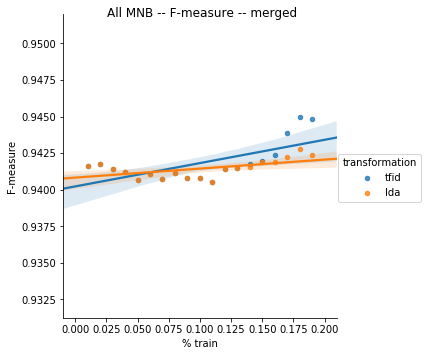

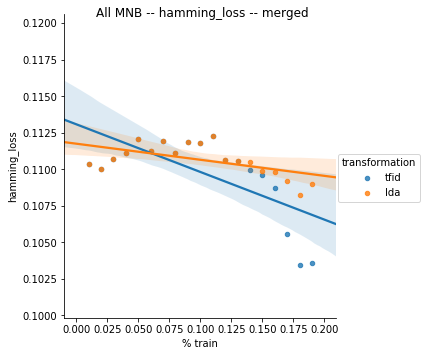

In [7]:
import pandas as pd
import seaborn as sns

#"BinaryRelevance(MultinomialNB()) + 'isLabeled','bug','isPullRequest','repo'"
strClassifier="MultinomialNB pull_request_merged"
#liststrLabelY=['isLabeled','bug', 'isPullRequest','repo']
#liststrLabelY=['isLabeled','bug', 'isPullRequest']
liststrLabelY=['merged']
#liststrLabelY=['repo']
#lmeasures=("F-measure","roc_auc_score","hamming_loss","accuracy")
lmeasures=("F-measure","hamming_loss")

for i,labelY in enumerate(liststrLabelY): 
    for measure in lmeasures:
        lm=sns.lmplot(x="% train",y=measure,data=dfresulty[i],hue="transformation",scatter_kws={"s":20, "alpha":0.8})
        fig=lm.fig
        fig.suptitle("All MNB -- " +  measure +" -- " +labelY)
      

## Evaluate classifier multiclass

Preconditions
- use a classifier multiclass in this case DecisionTreeClassifier. SVM could be used.
- use a metric multiclass (micro, macro) 

Data multiclass to classify: issue.repo
This experiment is valid if it is parsed issues of different repositories.
In this example we use the following representation:
df.replace('jquerytools', 0).replace('Chart.js', 1).replace('netty', 2).replace('RxJava', 3).replace('cakephp', 4).replace('angular.js', 5)

In [8]:
# Calcula F-Measure iterativamente obtenida con claificador Multinomial
# se analiza reduciendo el porcentaje de entrenamiento
def trainCorpusEvaluateMulticlass(df,str_y_columname,x_transformations):
    """Create a DecisionTreeClassifier multiclass classifier and it is trained iterative from train_size 1% to 40%.
    Measure are calculated FMeasure, hamming_loss,accuracy
    Parameters:
    ----------
    df: dataframe with issue information with class multiclass
    x_transformations : sparse vector with the corpus tf, tfid,lda,hdp
    str_y_columname: binary class name in dataframe 
    Returns:
    -------  
    dfresult - list with measures values for each trained set
    """
    #dfresult=pd.DataFrame(columns=["% train","transformation","F-measure","roc_auc_score","hamming_loss","accuracy"])
    dfresult=pd.DataFrame(columns=["% train","transformation","F-measure","hamming_loss"])
    for transformation in x_transformations:
        for i in range(1,20,1):
            train_size=i/100
            #X_train, X_test, y_train, y_test = train_test_split(transformation[1].transpose(), df[str_y_columname].values, train_size=train_size, random_state = 0)
            #X_train, X_test, y_train, y_test = train_test_split(transformation[1].transpose(), df[str_y_columname], train_size=train_size, random_state = 0)
            X_train, X_test, y_train, y_test = train_test_split(transformation[1].transpose(), np.array(df[str_y_columname]),train_size=train_size, random_state = 0)
            #clf = svm.SVC().fit(X_train, y_train)
            #print(type(y_train))
            #a1 = y_train
            #a2 = np.array(list(y_train))
            #print(dir(y_train))
            #print(dir(np.array(list(y_train))))
            #print('las diferentes son: ', [p for p in dir(np.array) if p[0]!='_' and not getattr(a1,p) == getattr(a2,p)])
            #print(multiclass.type_of_target(np.array(list(y_train))))
            
            #y_train_clear=np.array(list(y_train))
            clf= DecisionTreeClassifier().fit(X_train,y_train)
            y_test_predicted = clf.predict(X_test)
            
            #y_test_predicted_clear=np.array(list(y_test_predicted))
            #y_test_clear=np.array(list(y_test))
            
            f1=f1_score(y_test,y_test_predicted,average='macro')
            hamming=hamming_loss(y_test,y_test_predicted)
            dfaux=pd.DataFrame([[train_size,transformation[0], f1,hamming]],columns=["% train","transformation","F-measure","hamming_loss"])
            dfresult=dfresult.append(dfaux)
    return dfresult

dfresulty=[]

for strylabel in liststrLabelY:
    #dfresultyaux=trainCorpusEvaluateMulticlass(df,'repository_name',[["tfid",svtfid],["lda",svlda]])
    dfresultyaux=trainCorpusEvaluateMulticlass(df,'repository_id',[["tfid",svtfid],["lda",svlda]])
    dfresulty+=[dfresultyaux]
    
print(dfresulty)

/home/clopezno/anaconda3/envs/TextMining/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/clopezno/anaconda3/envs/TextMining/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[   % train transformation  F-measure  hamming_loss
0     0.01           tfid   0.317573      0.665962
0     0.02           tfid   0.336080      0.606592
0     0.03           tfid   0.475856      0.514614
0     0.04           tfid   0.480786      0.490680
0     0.05           tfid   0.449703      0.479452
0     0.06           tfid   0.538719      0.416316
0     0.07           tfid   0.517760      0.409045
0     0.08           tfid   0.537947      0.383935
0     0.09           tfid   0.555968      0.382022
0     0.10           tfid   0.586066      0.356829
0     0.11           tfid   0.577907      0.350653
0     0.12           tfid   0.565871      0.351466
0     0.13           tfid   0.589053      0.331731
0     0.14           tfid   0.602804      0.328290
0     0.15           tfid   0.609371      0.311372
0     0.16           tfid   0.609844      0.306224
0     0.17           tfid   0.619930      0.300392
0     0.18           tfid   0.622455      0.296968
0     0.19           tfid   0.

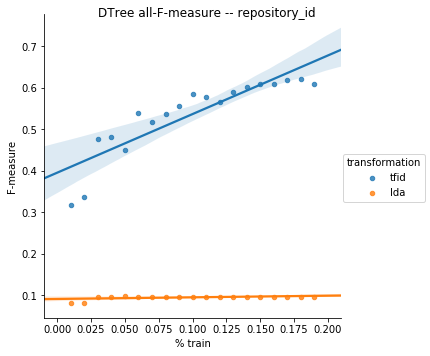

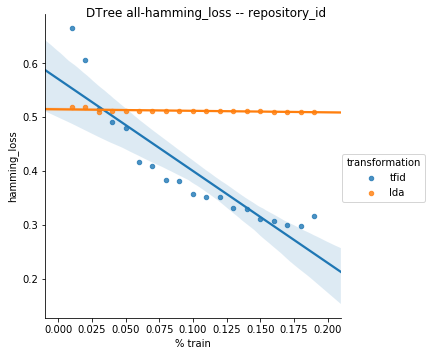

In [10]:
import pandas as pd
import seaborn as sns

#"BinaryRelevance(MultinomialNB()) + 'isLabeled','bug','isPullRequest','repo'"
strClassifier="DecisionTreeClassifier multiclass"
#liststrLabelY=['isLabeled','bug', 'isPullRequest','repo']
#liststrLabelY=['isLabeled','bug', 'isPullRequest']
liststrLabelY=['repository_id']
#liststrLabelY=['repo']
#lmeasures=("F-measure","roc_auc_score","hamming_loss","accuracy")
lmeasures=("F-measure","hamming_loss")

for i,labelY in enumerate(liststrLabelY): 
    for measure in lmeasures:
        lm=sns.lmplot(x="% train",y=measure,data=dfresulty[i],hue="transformation",scatter_kws={"s":20, "alpha":0.8})
        fig=lm.fig
        fig.suptitle("DTree all-"+ measure +" -- " +labelY)